In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['^IRX']

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^IRX    1259 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['^IRX']

#add in the weightage of stocks
port_shares = [1]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-09,0.485,0.485,-0.035785
...,...,...,...
2020-12-24,0.075,0.075,0.000000
2020-12-28,0.080,0.080,0.066667
2020-12-29,0.090,0.090,0.125000


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-09,0.485,0.485,-0.035785
...,...,...,...
2020-12-24,0.075,0.075,0.000000
2020-12-28,0.080,0.080,0.066667
2020-12-29,0.090,0.090,0.125000


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-07,0.503,0.503,-0.009843
...,...,...,...
2020-12-27,0.075,0.075,0.000000
2020-12-28,0.080,0.080,0.066667
2020-12-29,0.090,0.090,0.125000


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['^IRX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,0.475
2017-01-04,0.518
2017-01-05,0.508
2017-01-06,0.503
2017-01-07,0.503
...,...
2020-12-27,0.075
2020-12-28,0.080
2020-12-29,0.090


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2 3 4 5 6 7 8 9]
Observations : 1459


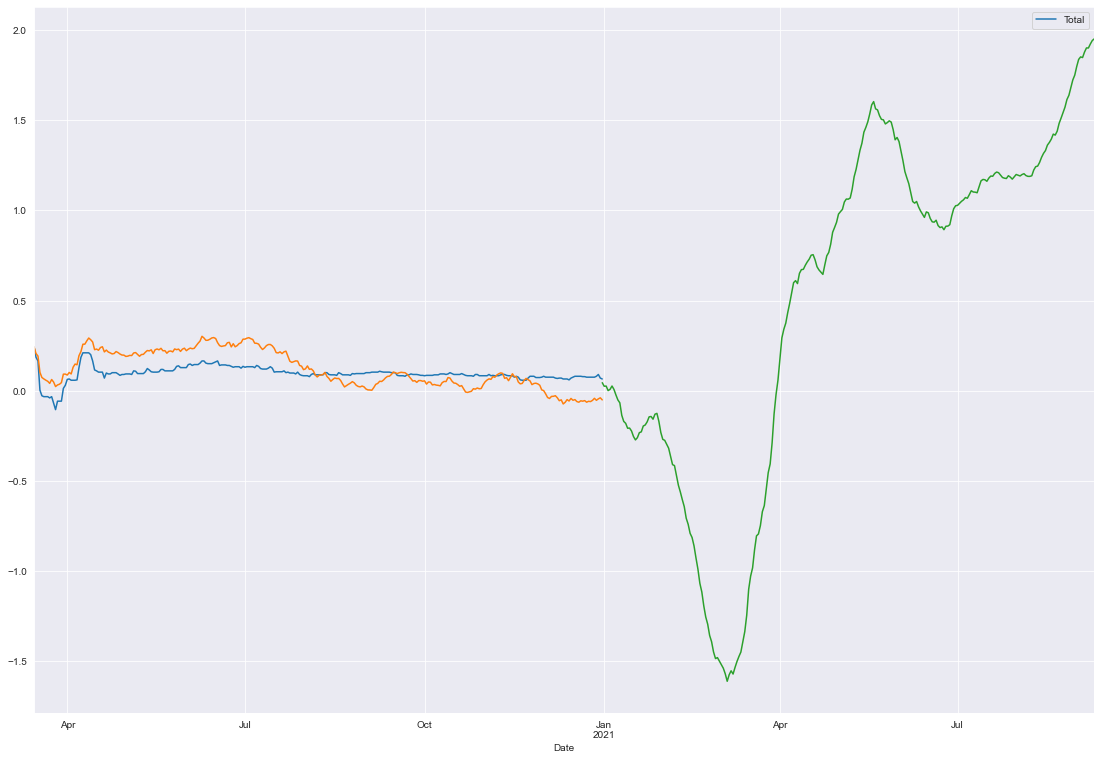

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2020-12-31    0.044393
2021-01-01    0.024796
2021-01-02    0.025643
2021-01-03    0.000546
2021-01-04    0.007559
                ...   
2021-09-05    1.900548
2021-09-06    1.900357
2021-09-07    1.922674
2021-09-08    1.941873
2021-09-09    1.950978
Freq: D, Length: 253, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2020-12-31,0.044393
2021-01-01,0.024796
2021-01-02,0.025643
2021-01-03,0.000546
2021-01-04,0.007559
...,...
2021-09-05,1.900548
2021-09-06,1.900357
2021-09-07,1.922674
2021-09-08,1.941873


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.441445
2021-01-02,-0.422352
2021-01-03,-0.987710
2021-01-04,-0.829713
...,...
2021-09-05,41.812248
2021-09-06,41.807932
2021-09-07,42.310651
2021-09-08,42.743146


In [26]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                      0
2021-09-09  4294.823113


## Backtesting

In [102]:
tickers2 = ['^TNX']

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [103]:
panel_data2 = panel_data2['Adj Close']

In [104]:
panel_data2

Symbols,^TNX
Date,
2017-01-03,2.450
2017-01-04,2.452
2017-01-05,2.368
2017-01-06,2.418
2017-01-09,2.376
...,...
2021-12-27,1.481
2021-12-28,1.481
2021-12-29,1.543


## Portfolio Analysis

In [105]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,^TNX
Date,
2017-01-04,0.000816
2017-01-05,-0.034258
2017-01-06,0.021115
2017-01-09,-0.017370
2017-01-10,0.001263


In [106]:
portfolio_weights = [1]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,^TNX
Date,
2017-01-04,0.000816
2017-01-05,-0.034258
2017-01-06,0.021115
2017-01-09,-0.017370
2017-01-10,0.001263


In [107]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2017-01-04    0.000816
2017-01-05   -0.034258
2017-01-06    0.021115
2017-01-09   -0.017370
2017-01-10    0.001263
dtype: float64

Start date,2017-01-04
End date,2021-12-31
Total months,59
,Backtest
Annual return,-9.2%
Cumulative returns,-38.3%
Annual volatility,60.4%
Sharpe ratio,0.13
Calmar ratio,-0.11
Stability,0.45
Max drawdown,-84.6%


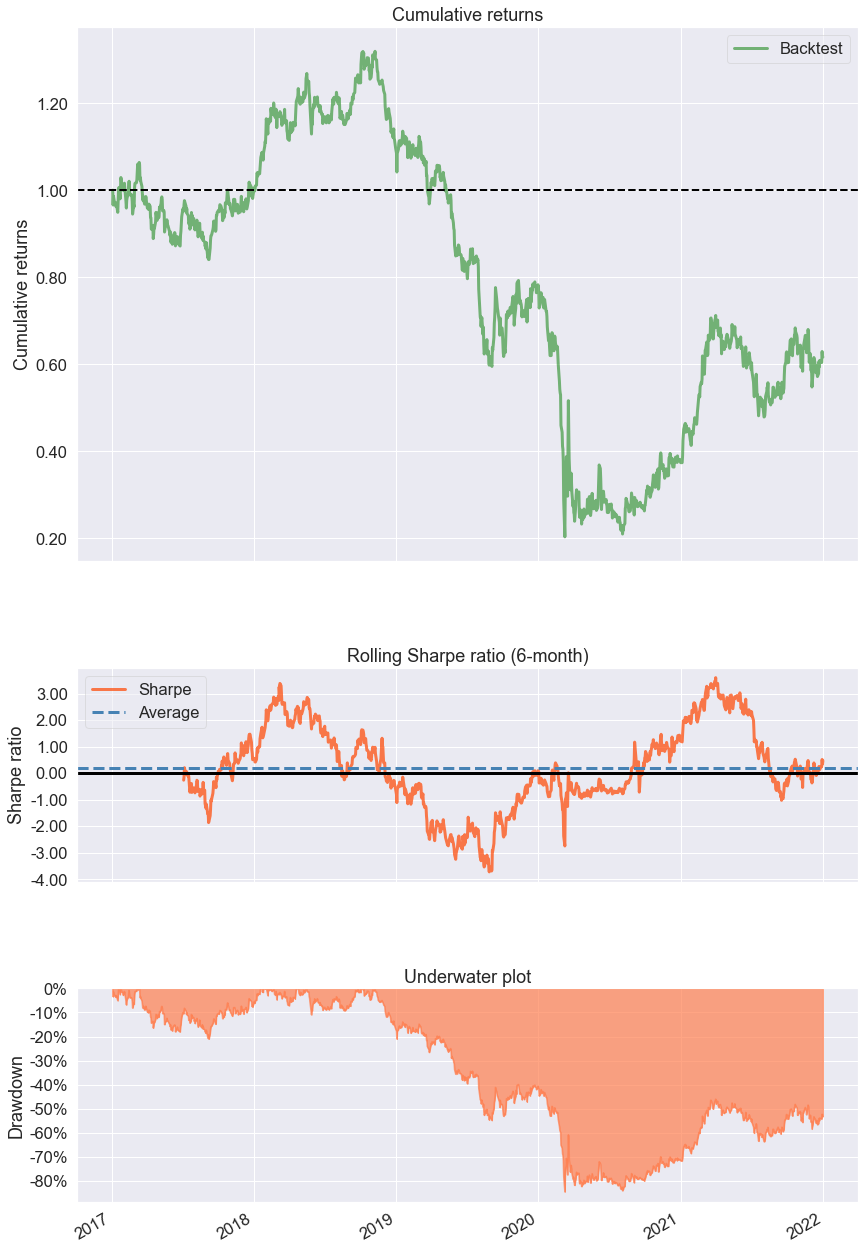

In [108]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [34]:
import itertools

In [35]:
weights = [1]

In [36]:
panel_data2 = panel_data2 * weights

In [37]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [38]:
#forecasted portfolio value
panel_data2

Symbols,^IRX,Total
Date,,
2020-12-30,0.070,0.070
2020-12-31,0.065,0.065
2021-01-04,0.068,0.068
2021-01-05,0.078,0.078
2021-01-06,0.078,0.078
...,...,...
2021-12-23,0.058,0.058
2021-12-27,0.043,0.043
2021-12-28,0.050,0.050


In [39]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [40]:
actual_portfolio_value

[0.07000000029802322,
 0.06499999761581421,
 0.06800000369548798,
 0.07800000160932541,
 0.07800000160932541,
 0.07999999821186066,
 0.07999999821186066,
 0.07999999821186066,
 0.07999999821186066,
 0.07999999821186066,
 0.07500000298023224,
 0.07500000298023224,
 0.0729999989271164,
 0.07500000298023224,
 0.0729999989271164,
 0.07000000029802322,
 0.07000000029802322,
 0.06800000369548798,
 0.05999999865889549,
 0.054999999701976776,
 0.04800000041723251,
 0.04800000041723251,
 0.05000000074505806,
 0.03999999910593033,
 0.029999999329447746,
 0.023000000044703484,
 0.019999999552965164,
 0.032999999821186066,
 0.03500000014901161,
 0.03500000014901161,
 0.03500000014901161,
 0.03500000014901161,
 0.03500000014901161,
 0.023000000044703484,
 0.023000000044703484,
 0.02500000037252903,
 0.023000000044703484,
 0.02800000086426735,
 0.032999999821186066,
 0.03500000014901161,
 0.02800000086426735,
 0.03500000014901161,
 0.03500000014901161,
 0.02800000086426735,
 0.02800000086426735,
 0.

In [41]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [42]:
forecasted_portfolio_value

[0.044392630346678924,
 0.024795747295903572,
 0.02564332172758818,
 0.0005455772347236071,
 0.00755946698490606,
 0.026067780001456806,
 0.007095374321684972,
 -0.02335726004918219,
 -0.05101925226419626,
 -0.06711216495870762,
 -0.13638380462178656,
 -0.17008958737476834,
 -0.18088110942652275,
 -0.20808134973853165,
 -0.20715869139829146,
 -0.22351649031988424,
 -0.25398431293636187,
 -0.27281143547329934,
 -0.2603740262859538,
 -0.23271028975514513,
 -0.22813778038536647,
 -0.19594359594769467,
 -0.190064197066302,
 -0.17263563370574747,
 -0.14504248741178213,
 -0.14298861950557035,
 -0.15811049878725414,
 -0.13027638454025803,
 -0.12566720783847463,
 -0.1700928302490686,
 -0.23164232278608374,
 -0.2696809651334343,
 -0.2753025405179547,
 -0.2974201253712333,
 -0.31872155167624594,
 -0.36521594464529245,
 -0.40983020442153223,
 -0.41526571777730337,
 -0.4709429949119436,
 -0.524225068483331,
 -0.5616486291639531,
 -0.603860805905372,
 -0.6426665011987162,
 -0.7068719110265763,
 -0.

## Calculate MAPE of forecasted period

In [43]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 46.92
MAPE % : 4692.46 %



## Mean Squared Error

In [44]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

1.149431795423826


## Forecast for future

In [45]:
#change to the list of stocks we using
port_list = ['^IRX']

#add in the weightage of stocks
port_shares = [1]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-09,0.485,0.485,-0.035785
...,...,...,...
2021-12-27,0.043,0.043,-0.258621
2021-12-28,0.050,0.050,0.162791
2021-12-29,0.045,0.045,-0.100000


In [46]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-09,0.485,0.485,-0.035785
...,...,...,...
2021-12-27,0.043,0.043,-0.258621
2021-12-28,0.050,0.050,0.162791
2021-12-29,0.045,0.045,-0.100000


In [47]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [48]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [49]:
tot_port_df

,^IRX,Total,daily_return
Date,,,
2017-01-03,0.475,0.475,NaN
2017-01-04,0.518,0.518,0.090526
2017-01-05,0.508,0.508,-0.019305
2017-01-06,0.503,0.503,-0.009843
2017-01-07,0.503,0.503,-0.009843
...,...,...,...
2021-12-27,0.043,0.043,-0.258621
2021-12-28,0.050,0.050,0.162791
2021-12-29,0.045,0.045,-0.100000


In [50]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['^IRX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [51]:
tot_port_df

,Total
Date,
2017-01-03,0.475
2017-01-04,0.518
2017-01-05,0.508
2017-01-06,0.503
2017-01-07,0.503
...,...
2021-12-27,0.043
2021-12-28,0.050
2021-12-29,0.045


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Observations : 1824


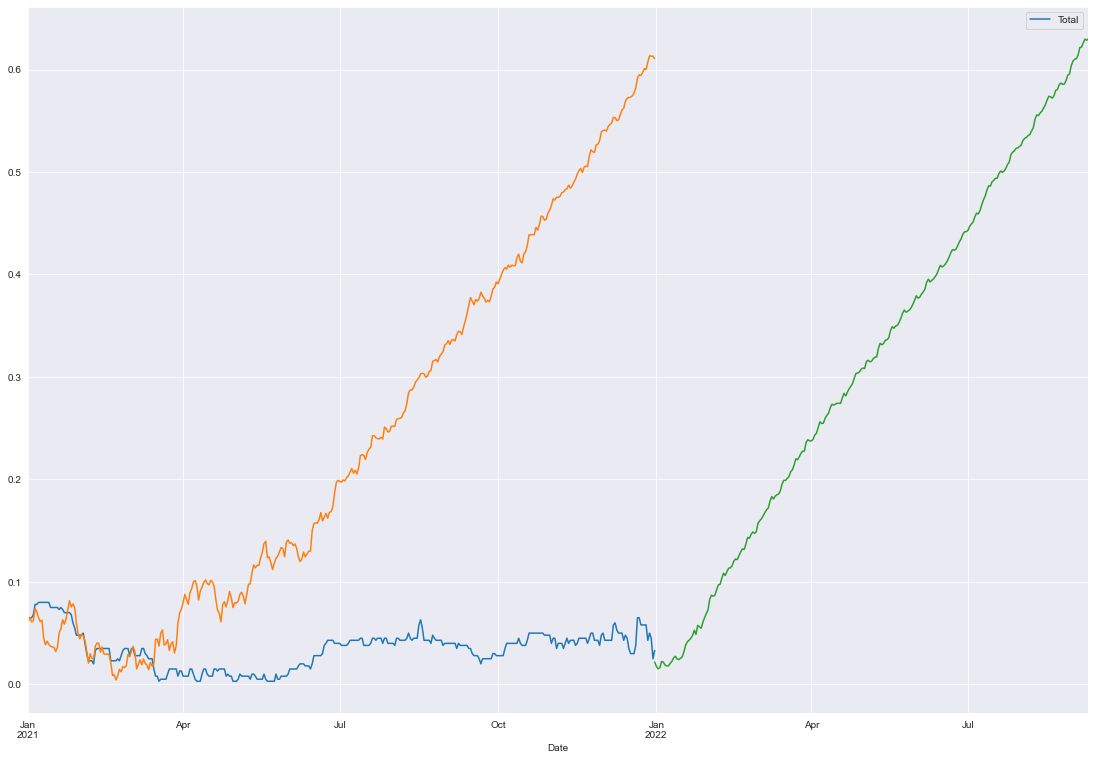

In [52]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [53]:
## Calculate annualized returns for forecasted

In [54]:
forecast

2021-12-31    0.021753
2022-01-01    0.017516
2022-01-02    0.015170
2022-01-03    0.016240
2022-01-04    0.022286
                ...   
2022-09-05    0.621897
2022-09-06    0.625998
2022-09-07    0.629671
2022-09-08    0.628582
2022-09-09    0.629934
Freq: D, Length: 253, dtype: float64

In [55]:
forecast_df = pd.DataFrame(forecast)

In [56]:
forecast_df

,0
2021-12-31,0.021753
2022-01-01,0.017516
2022-01-02,0.015170
2022-01-03,0.016240
2022-01-04,0.022286
...,...
2022-09-05,0.621897
2022-09-06,0.625998
2022-09-07,0.629671
2022-09-08,0.628582


In [57]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [58]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.194747
2022-01-02,-0.302622
2022-01-03,-0.253409
2022-01-04,0.024540
...,...
2022-09-05,27.589607
2022-09-06,27.778143
2022-09-07,27.946995
2022-09-08,27.896929


In [59]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                      0
2022-09-09  2795.908254
